# Mixing in Gaussian turbulence field: Perseus cluster and from NGC 1275

This tutorial demonstrates how to calculate the photon-ALP transition probability in a magnetic field with Gaussian turbulence on the example of the Perseus cluster with the central radio galaxy NGC 1275. The assumed B-field environments are the same as in <a href="http://inspirehep.net/record/1432667">Ajello et al. (2016)</a>   and include the cluster field and the magnetic field of the Milky Way. 

We start of with the usual imports:

In [1]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from ebltable.tau_from_model import OptDepth
from astropy import constants as c

And initialize an ALP object, which stores the ALP mass $m_a$ (in neV) and the coupling $g_{a\gamma}$ (in $10^{-11}\mathrm{GeV}^{-1}$).

In [2]:
m, g = 1.,1.
alp = ALP(m,g)

Next, we set the source properties (redshift and sky coordinates) in the ```Source``` container. These can be taken form your favorite catalot for extragalactic objects, e.g., <a href="http://ned.ipac.caltech.edu/byname?objname=NGC%201275&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1">NED</a>.

In [3]:
ngc1275 = Source(z=0.017559, ra='03h19m48.1s', dec='+41d30m42s')
print (ngc1275.z)
print (ngc1275.ra, ngc1275.dec)
print (ngc1275.l, ngc1275.b)

0.017559
49.950416666666655 41.51166666666666
150.57567432060083 -13.261343544296357


### Init the module list
Next, we can initialize the list of transfer modules that will store the different magnetic field environments. 
First, we provide the energies for which we would like to compute the conversion probability

In [4]:
EGeV = np.logspace(1., 3.5, 250)

Now initialize the initial photon polarization. Since we are dealing with a gamma-ray source, no ALPs are initially present in the beam (third diagonal element is zero). The polarization density matrix is normalized such that its trace is equal to one, $\mathrm{Tr}(\rho_\mathrm{in}) = 1$.

In [5]:
pin = np.diag((1.,1.,0.)) * 0.5

The module list is initialized with our choices for the ALP, our source, the initial polarization, and the energies at which we compute the photon-ALP mixing

In [6]:
ml = ModuleList(alp, ngc1275, pin = pin, EGeV = EGeV)

Now we add propagation modules for the cluster, the EBL, and the Galactic magnetic field.
By setting `nsim=10` we calculate 10 random realizations of the magnetic field.

In [7]:
ml.add_propagation("ICMGaussTurb", 
                  0, # position of module counted from the source. 
                  nsim=10, # number of random B-field realizations
                  B0=10.,  # rms of B field in muG
                  n0=3.9e-2,  # normalization of electron density in cm-3
                  n2=4.05e-3, # second normalization of electron density, see Churazov et al. 2003, Eq. 4 on cm-3
                  r_abell=500., # extension of the cluster in kpc
                  r_core=80.,   # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  r_core2=280., # electron density parameter, see Churazov et al. 2003, Eq. 4 in kpc
                  beta=1.2,  # electron density parameter, see Churazov et al. 2003, Eq. 4
                  beta2=0.58, # electron density parameter, see Churazov et al. 2003, Eq. 4
                  eta=0.5, # scaling of B-field with electron denstiy
                  kL=0.18, # maximum turbulence scale in kpc^-1, taken from A2199 cool-core cluster, see Vacca et al. 2012 
                  kH=9.,  # minimum turbulence scale, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  q=-2.80, # turbulence spectral index, taken from A2199 cool-core cluster, see Vacca et al. 2012
                  seed=0 # random seed for reproducability, set to None for random seed.
                 )
ml.add_propagation("EBL",1, eblmodel='dominguez') # EBL attenuation comes second, after beam has left cluster
ml.add_propagation("GMF",2, model='jansson12') # finally, the beam enters the Milky Way Field

environs.py: 431 --- INFO: Using inputted chi
environs.py:1039 --- INFO: Using inputted chi


List the module names:

In [8]:
print(ml.modules.keys())

['MixICMGaussTurb', 'OptDepth', 'MixGMF']


We can also change the ALP parameters before running the modules:

In [9]:
ml.alp.m = 30.
ml.alp.g = 0.5

We can also inspect the magnetic-field realization and electron density along the line of sight. The magnetic-field realizations are stored in `ml.modules["ICMGaussTurb"].Bn`,

In [10]:
print (ml.modules["ICMGaussTurb"].Bn.shape)

(10, 4499)


And multiplying the magnetic field with the $\psi$ angles stored in `ml.modules["ICMGaussTurb"].Psin` will give us the two components transversal to the propagation direction:

Text(0.5, 0, '$r$ (kpc)')

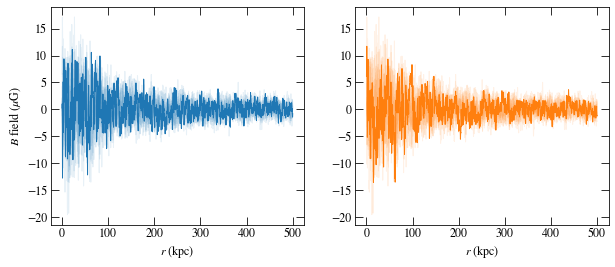

In [11]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, B in enumerate(ml.modules["ICMGaussTurb"].Bn):
    ax1.plot(ml.modules["ICMGaussTurb"].r,
             B * np.sin(ml.modules["ICMGaussTurb"].psin[i]),
             lw=1,
             alpha=1 if not i else 0.1,
             color=plt.cm.tab10(0.)
            )
    ax2.plot(ml.modules["ICMGaussTurb"].r,
             B * np.cos(ml.modules["ICMGaussTurb"].psin[i]),
             lw=1,
             alpha=1 if not i else 0.1,
             color=plt.cm.tab10(0.1)
            ) 
    
ax1.set_ylabel('$B$ field ($\mu$G)')
ax1.set_xlabel('$r$ (kpc)')
ax2.set_xlabel('$r$ (kpc)')

The coherent magnetic field in the Milky Way used in the mixing can be plotted in a similar way. Note that we're using the attributes `ml.modules["GMF"].B` and `ml.modules["GMF"].psi` since we are dealing with one coherent magnetic field and not many random realizations. 

Text(0.5, 0, '$r$ (kpc)')

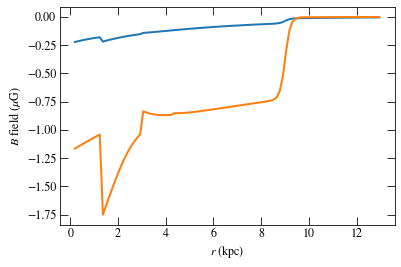

In [12]:
plt.plot(ml.modules["GMF"].r, ml.modules["GMF"].B * np.sin(ml.modules["GMF"].psi),
         lw=2)
plt.plot(ml.modules["GMF"].r, ml.modules["GMF"].B * np.cos(ml.modules["GMF"].psi),
         lw=2) 
plt.ylabel('$B$ field ($\mu$G)')
plt.xlabel('$r$ (kpc)')

The electron density in our Perseus cluster model looks like this

Text(0.5, 0, '$r$ (kpc)')

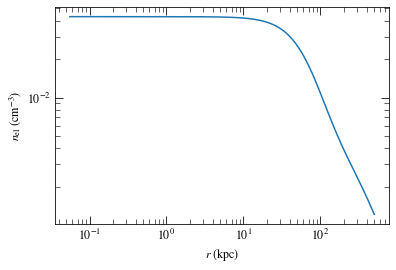

In [13]:
plt.loglog(ml.modules["ICMGaussTurb"].r, ml.modules["ICMGaussTurb"].nel)
plt.ylabel('$n_\mathrm{el}$ (cm$^{-3}$)')
plt.xlabel('$r$ (kpc)')

### Run all modules

Now we run the modules. If ```multiprocess``` key word is larger than two, this will be split the calculation of the oscillation probability for the random realizations onto multiple cores with python's ```multiprocess``` module.

The ```px, py, pa``` variables contain the mixing probability into the two photon polarization states ($x$, $y$) and into the axion state ($a$).

In [ ]:
px, py, pa = ml.run(multiprocess=4)

   core.py: 644 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixICMGaussTurb'>


### Plot the output 

Finally, we now plot the resulting total survival probability, $P_{\gamma\gamma} = P_x + P_y$ for each 
magnetic-field realization.

In [ ]:
pgg = px + py # the total photon survival probability

effect = dict(path_effects=[withStroke(foreground="w", linewidth=2)])

for i, p in enumerate(pgg):  # plot all realizations
    plt.loglog(ml.EGeV, p, color=plt.cm.tab10(0.), alpha=1 if not i else 0.2)

plt.xlabel('Energy (GeV)')
plt.ylabel('Photon survival probability')

plt.annotate(r'$m_a = {0:.1f}\,\mathrm{{neV}}, g_{{a\gamma}}'
             r' = {1:.1f} \times 10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$'.format(ml.alp.m, ml.alp.g),
             xy=(0.05,0.1), 
             size ='x-large',
             xycoords='axes fraction',
             **effect)